In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

from collections import defaultdict

import math

import pandas as pd

import optuna

import joblib

import tcn

import HydroErr

from matplotlib import pyplot as plt

In [27]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENT = 1758

EPOCHS = 500

train_year = 29 # 29 years of data contained in the train_val splits of the Caravan dataset

PATIENCE = 10

dtypes = defaultdict(lambda: float)
dtypes["catchment_id"] = str

use_amp = True # use Automatic Mixed Precision to speed up training

In [28]:
base_TCN_study = joblib.load('data/base_TCN_study.pkl')

In [29]:
class Forcing_Data(Dataset):
    def __init__(
        self,
        fpath="data/Caravan/data_train_w_missing.csv",
        record_length=7304,
        n_feature=3,
    ):
        data_raw = pd.read_csv(fpath, dtype=dtypes)

        # normalization and then reshape to catchment*record*feature
        x = data_raw.loc[:, "P":"PET"]

        x = torch.tensor(x.values, dtype=torch.float32)
        x = x.view(-1, record_length, n_feature)
        self.x = x.to(DEVICE)

        # normalization and then reshape to catchment*record
        y = data_raw["Q"]

        y = torch.tensor(y.values, dtype=torch.float32)
        y = y.view(-1, record_length)
        self.y = y.to(DEVICE)

        self.record_length = self.x.shape[1]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

    def get_random_batch(self):
        # This fuction return a input and output pair for each catchment
        # SEQ_LENGTH, BASE_LENGTH, and DEVICE is from global
        # reference: https://medium.com/@mbednarski/understanding-indexing-with-pytorch-gather-33717a84ebc4
        # https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms

        # randomly selects a starting time step for each catchment
        index = torch.randint(
            low=0,
            high=self.record_length - SEQ_LENGTH + 1,
            size=(N_CATCHMENT,),
            device=DEVICE,
        )

        # expand the index to have the length of SEQ_LENGTH, adding 0 to SEQ_LENGTH to get correct index
        index_y = index.unsqueeze(-1).repeat(1, SEQ_LENGTH) + torch.arange(
            SEQ_LENGTH, device=DEVICE
        )
        index_x = index_y.unsqueeze(-1).repeat(1, 1, FORCING_DIM)

        # use gather function to output values
        x_batch, y_batch = self.x.gather(dim=1, index=index_x), self.y.gather(
            dim=1, index=index_y
        )

        return x_batch, y_batch[:, BASE_LENGTH:]

    def get_val_batch(self, device=DEVICE):
        n_years = math.ceil((self.record_length - BASE_LENGTH) / TARGET_SEQ_LENGTH)

        out_x = (
            torch.ones([n_years, N_CATCHMENT, SEQ_LENGTH, FORCING_DIM], device=device)
            * torch.nan
        )
        out_y = (
            torch.ones([n_years, N_CATCHMENT, SEQ_LENGTH], device=device) * torch.nan
        )

        for i in range(n_years):
            start_record_ind = BASE_LENGTH * i

            if i == n_years - 1:
                end_record_ind = self.record_length

                out_x[i, :, 0 : (end_record_ind - start_record_ind), :] = self.x[
                    :, start_record_ind:end_record_ind, :
                ]
                out_y[i, :, 0 : (end_record_ind - start_record_ind)] = self.y[
                    :, start_record_ind:end_record_ind
                ]

            else:
                end_record_ind = start_record_ind + SEQ_LENGTH

                out_x[i, :, :, :] = self.x[:, start_record_ind:end_record_ind, :]
                out_y[i, :, :] = self.y[:, start_record_ind:end_record_ind]

        return out_x, out_y[:, :, BASE_LENGTH:]

In [ ]:
fpath="data/data_test_w_missing.csv"

In [30]:
dtrain_val = Forcing_Data("data/data_train_val_w_missing.csv", record_length=10956)
dtest = Forcing_Data("data/data_test_w_missing.csv", record_length=4017)

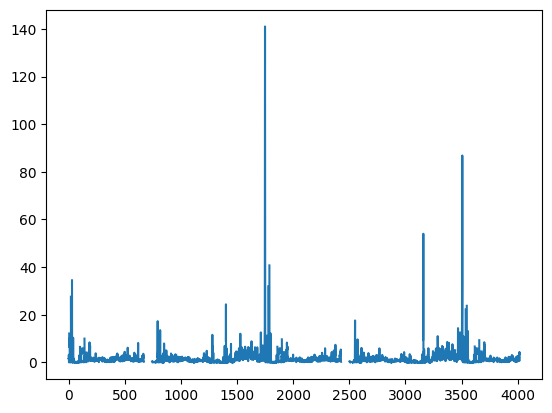

In [164]:
plt.plot(dtest.y[1,:])

In [31]:
class Decoder(nn.Module):
    def __init__(
        self,
        latent_dim,
        feature_dim,
        num_channels,
        kernel_size,
        p=0.2,
    ):
        super(Decoder, self).__init__()

        self.num_inputs = latent_dim + feature_dim
        self.num_channels = num_channels
        self.kernel_size = kernel_size
        self.p = p

        self.tcn = tcn.TemporalConvNet(
            num_inputs=self.num_inputs,
            num_channels=self.num_channels,
            kernel_size=self.kernel_size,
            dropout=self.p,
        )

    def forward(self, inputs):
        """Forward pass

        Args:
            inputs (tensor): shape = [batch_size, input channels, seq_len]

        Returns:
            tensor: shape = [batch_size, output channels, seq_len]
        """
        return self.tcn(inputs)

    def decode(self, code, x, base_length=BASE_LENGTH):
        """Predict hydrographs under forcing x for catchments charaterized by `code`

        Args:
            code (tensor): shape = [batch_size, latent dim]
            x (tensor): shape = [batch_size, seq_len, latent dim]
            base_length (int): predictions for the first 'base_length' time step is ignored. Defaults to BASE_LENGTH.

        Returns:
            tensor: shape = [base_size, seq_len - base_length]
        """

        code = code.expand(x.shape[1], -1, -1).transpose(
            0, 1
        )  # new shape [batch_size, seq_len, latent dim

        x = torch.cat((code, x), 2)  # concatenate code and x in dim 2

        x = x.transpose(
            1, 2
        ).contiguous()  # new shape [batch_size, input channel, seq_len]

        out = (
            self.tcn(x).transpose(1, 2)[:, base_length:, :].squeeze()
        )  # new shape [batch_size, Target length]

        return out

In [32]:
def mse_loss_with_nans(input, target):
    # Adapted from https://stackoverflow.com/a/59851632/3361298

    # Missing data are nans
    mask = torch.isnan(target)

    out = (input[~mask] - target[~mask]) ** 2
    loss = out.mean()

    return loss

In [39]:
def val_model(
    embedding, decoder, dataset, val_metric=mse_loss_with_nans, return_summary=True
):
    """Validate embedding and decoder using the validation batch from dataset and val_metric.

    Args:
        embedding (Embedding): model that map catchment_id (Tensor.int) to latent code [tensor].
        decoder (Decoder): decorder model.
        dataset (Forcing_Data): dataset to be used in validation.
        val_metric (function, optional): compute gof metric. Defaults to mse_loss_with_nans.
        return_summary (bool, optional): whether the gof metric or the raw prediciton should be returned. Defaults to True.

    Returns:
        tensor: gof metric or raw prediction.
    """
    x, y = dataset.get_val_batch()

    embedding.eval()
    decoder.eval()

    preds = torch.ones(size=y.shape).to(DEVICE)

    selected_catchments = torch.arange(N_CATCHMENT).to(DEVICE)

    with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
        with torch.no_grad():
            code = embedding(selected_catchments)

            for i in range(x.shape[0]):
                x_sub = x[i, :, :, :]
                preds[i, :, :] = decoder.decode(code, x_sub)

    if return_summary:
        out = val_metric(preds, y)
    else:
        out = (preds, y)

    return out

In [34]:
def define_model(trial):

    # FORCING_DIM is from global

    # latent dim
    latent_dim_power = trial.suggest_int("latent_dim_power", 1, 2)
    latent_dim = 2**latent_dim_power

    # kernel_size
    kernel_size = trial.suggest_int("kernel_size", 2, 6)

    # num_channels
    # ref: https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/
    hidden_channel_dim = trial.suggest_int("hidden_channel_dim", 1, 256)
    base = 2  # dilation factor
    n_levels = math.log(
        (BASE_LENGTH - 1) * (base - 1) / (kernel_size - 1) / 2 + 1
    ) / math.log(2)
    n_levels = math.ceil(n_levels)

    num_channels = []
    for i in range(n_levels - 1):
        num_channels.append(hidden_channel_dim)

    num_channels.append(1)  # output dim = 1

    # p
    drop_out_flag = trial.suggest_categorical("drop_out_flag", [True, False])

    if drop_out_flag:
        p = trial.suggest_float("dropout_rate", 0.1, 0.5)
    else:
        p = 0

    # define model
    decoder = Decoder(
        latent_dim=latent_dim,
        feature_dim=FORCING_DIM,
        num_channels=num_channels,
        kernel_size=kernel_size,
        p=p,
    )

    embedding = nn.Embedding(N_CATCHMENT, latent_dim)

    return embedding, decoder

In [35]:
def get_optimal_epochs(study):
    
    stats = study.best_trials[0].intermediate_values
    EPOCHS = min(stats, key=lambda k: stats[k]) + 1
    
    return EPOCHS

In [36]:
def get_final_models(study = base_TCN_study, dataset = dtrain_val, train_year = 29):
    
    # optimal EPOCHS
    EPOCHS = get_optimal_epochs(study)
    trial = study.best_trials[0]

    # define model
    embedding, decoder = define_model(trial)
    embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)
    
    # define optimizers
    lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

    lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # define batch size
    batch_size_power = trial.suggest_int("batch_size_power", 4, 7)
    batch_size = 2**batch_size_power
    
    # define optimizers
    lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

    lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # define batch size
    batch_size_power = trial.suggest_int("batch_size_power", 4, 7)
    batch_size = 2**batch_size_power
    
    # train model
    for epoch in range(EPOCHS):
        # for each epoch get_random_batch method generates a batch that contains one year data for each catchment
        # repeat TRAIN_YEAR times to finish an epoch
        decoder.train()
        embedding.train()

        for year in range(train_year):

            x_batch, y_batch = dataset.get_random_batch()
            catchment_index = torch.randperm(N_CATCHMENT).to(DEVICE)  # add randomness

            # interate over catchments
            for i in range(int(N_CATCHMENT / batch_size)):

                # prepare data
                ind_s = i * batch_size
                ind_e = (i + 1) * batch_size

                selected_catchments = catchment_index[ind_s:ind_e]

                x_sub, y_sub = x_batch[ind_s:ind_e, :, :], y_batch[ind_s:ind_e, :]

                # prepare training, put the models into training mode
                decoder_optimizer.zero_grad()
                embedding_optimizer.zero_grad()

                # forward pass
                with torch.autocast(
                    device_type="cuda", dtype=torch.float16, enabled=use_amp
                ):
                    code = embedding(selected_catchments)
                    out = decoder.decode(code, x_sub)

                    # backprop
                    loss = mse_loss_with_nans(out, y_sub)

                scaler.scale(loss).backward()
                scaler.step(embedding_optimizer)
                scaler.step(decoder_optimizer)
                scaler.update()
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    return embedding, decoder


In [37]:
embedding, decoder = get_final_models(study=base_TCN_study, dataset=dtrain_val, train_year=29)

/Users/yang/opt/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/Users/yang/opt/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


KeyboardInterrupt: 

In [ ]:
torch.save(embedding.cpu(), "embedding.pt")
torch.save(decoder.cpu(), "decoder.pt")

In [41]:
embedding = torch.load("data/embedding.pt", map_location=torch.device('cpu'))
decoder = torch.load("data/decoder.pt", map_location=torch.device('cpu'))
embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)

In [44]:
preds, y_true = val_model(embedding, decoder, dtest, return_summary = False)

/Users/yang/opt/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [113]:
preds.shape, y_true.shape

(torch.Size([11, 1758, 365]), torch.Size([11, 1758, 365]))

In [49]:
preds2 = torch.ones([preds.shape[1], preds.shape[0]*preds.shape[2]])*np.nan
y_true2 = torch.ones([preds.shape[1], preds.shape[0]*preds.shape[2]])*np.nan

In [114]:
y_true2.shape, preds2.shape

(torch.Size([1758, 4015]), torch.Size([1758, 4015]))

In [116]:
for i in range(preds.shape[0]):
    ind_s = preds.shape[2]*i
    ind_e = preds.shape[2]*(i+1)
    
    preds2[:,ind_s:ind_e] = preds[i,:,:]
    y_true2[:,ind_s:ind_e] = y_true[i,:,:]

In [151]:
preds2 = preds2.numpy()
y_true2 = y_true2.numpy()

In [152]:
nse = np.ones(preds2.shape[0])
kges = np.ones(preds2.shape[0])
rmse = np.ones(preds2.shape[0])

for i in range(preds2.shape[0]):
    nse[i] = HydroErr.nse(simulated_array=preds2[i,:], observed_array=y_true2[i,:])
    kges[i] = HydroErr.kge_2009(simulated_array=preds2[i,:], observed_array=y_true2[i,:])
    rmse[i] = HydroErr.rmse(simulated_array=preds2[i,:], observed_array=y_true2[i,:])

/Users/yang/opt/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [ 116  140  148  152  154  155  160  161  163  164  165  178  188  189
  192  226  236  249  250  251  252  253  255  257  258  262  263  275
  276  284  294  297  300  303  305  307  309  311  324  367  372  374
  375  379  382  385  386  472  805  806  807  808  809  810  812  813
  814  815  816  817  818  819  820  821  822  823  824  825  826  827
  828  829  830  832  833  834  835  836  837  838  839  840  841  842
  844  845  846  847  848  849  850  851  852  853  854  856  857  858
  859  860  861  862  863  864  865  866  867  868  869  870  871  872
  873  874  875  876  878  882  883  884  890  891  893  894  896  897
  898  899  900  901  902  903  910  911  912  914  915  916  944  976
  977  980 1041 1396 1513 1528 1535 1539 1557 1592 1721 1752 1874 1898
 1906 1910 1912 1913 1918 1919 1921 1922 1923 1936 1946 1947 1950 1984
 1994 2007 2008 2009 2010 201

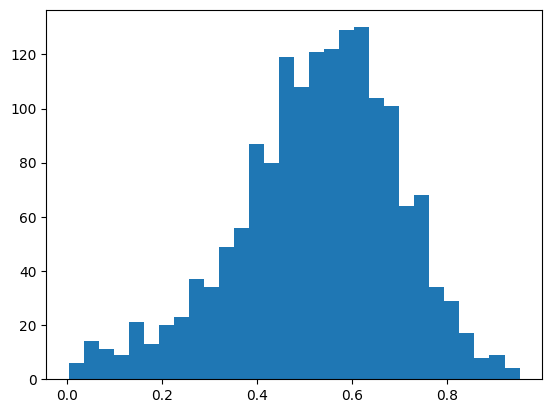

In [153]:
plt.hist(nse[nse>0], bins = 30)
plt.show()

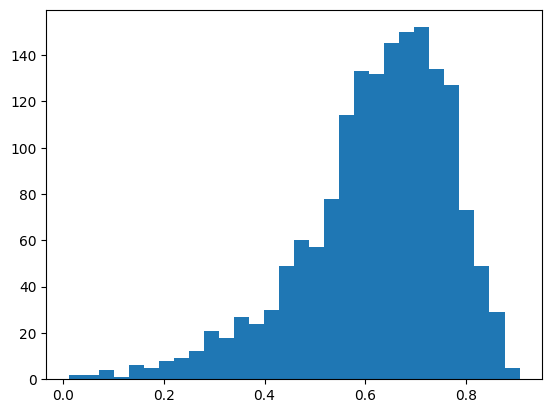

In [154]:
plt.hist(kges[kges>0], bins = 30)
plt.show()

In [155]:
kges.mean()

nan

In [73]:
kges[~np.isnan(kges)].mean()

0.6159013599764546

In [70]:
nse[~np.isnan(nse)].mean()

-inf

In [87]:
invalid_preds = preds2[np.isnan(nse),:]
invalid_ytrue = y_true2[np.isnan(nse),:]

In [88]:
invalid_preds.shape, invalid_ytrue.shape

(torch.Size([90, 4015]), torch.Size([90, 4015]))

In [158]:
print(kges)

[0.57735782 0.43939319 0.5287907  ...        nan        nan        nan]


In [126]:
preds.shape

torch.Size([11, 1758, 365])

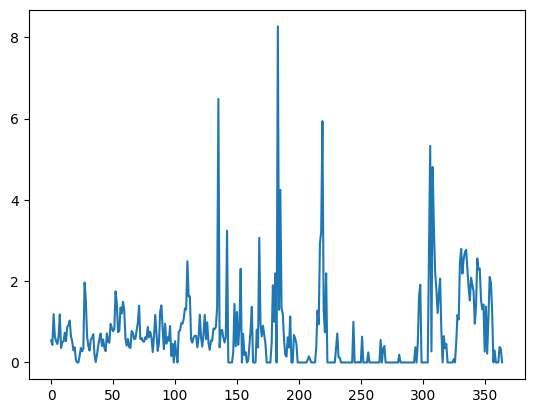

In [129]:
plt.plot(preds[2,1,:].numpy())

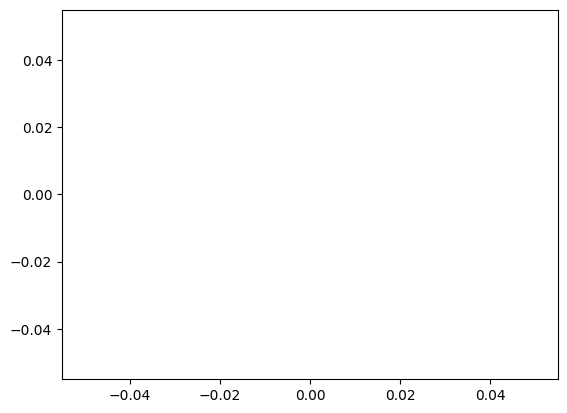

In [98]:
plt.plot(invalid_ytrue[1,:])

In [102]:
sum(np.isnan(invalid_ytrue[1,:]))

tensor(175, dtype=torch.uint8)

In [103]:
temp = invalid_ytrue[1,:]

In [106]:
temp[~torch.isnan(temp)]

tensor([])

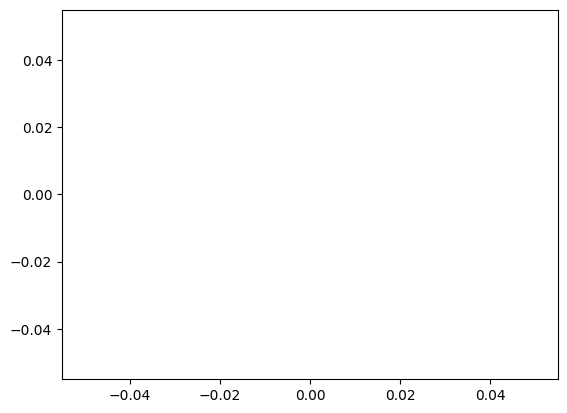

In [159]:
plt.plot(dtest.y.numpy()[-1,:])

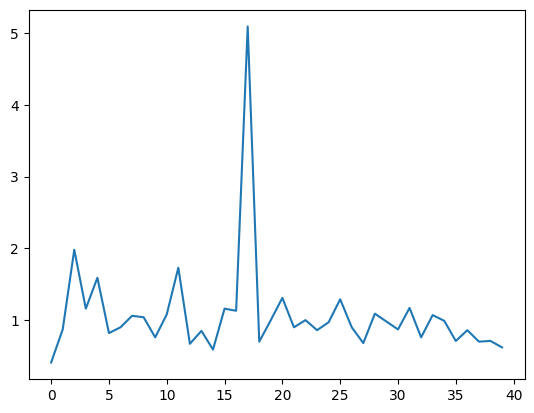

In [145]:
plt.plot(dtest.y.numpy()[10,0:40])